In [1]:
!pip install pandas matplotlib numpy keras

  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.7 MB/s eta 0:00:00
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/81/c4/34e93fe5f5429d7570ec1fa436f1986fb1f00c3e0f43a589fe2bbcd22c3f/pytz-2025.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/5c/23/c7abc0ca0a1526a0774eca151daeb8de62ec457e77262b66b359c3c7679e/tzdata-2025.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 42.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 119.0 MB/s eta 0:00:00

[notice] A ne

In [2]:
# Load libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
import datetime
import math
from numpy.random import choice
import random
from collections import deque
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.optimizers import Adam

2025-04-23 18:39:07.951320: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-23 18:39:07.988286: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 18:39:07.988310: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 18:39:07.988345: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-23 18:39:07.996410: I tensorflow/core/platform/cpu_feature_g

In [3]:
# Load the data
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/My Drive/cs4100 project - reinforcement learning in stock trading/

#The data already obtained from yahoo finance is imported.
dataset = read_csv('QQQ_10y.csv',index_col=0)

# Data Exploration

In [4]:
# Shape
dataset.shape

(2516, 6)

In [5]:
# Display the first few rows of the dataset
display(dataset.head())

,Open,High,Low,Close,Adj Close,Volume
2015-04-20,106.54,107.79,106.50,107.60,99.499432,28945909.0
2015-04-21,108.22,108.41,107.93,108.06,99.924802,22759772.0
2015-04-22,108.34,108.83,107.64,108.65,100.470384,21429190.0
2015-04-23,108.28,109.55,108.26,109.06,100.849518,29473221.0
2015-04-24,110.21,110.69,110.03,110.54,102.218097,32508127.0


<Axes: >

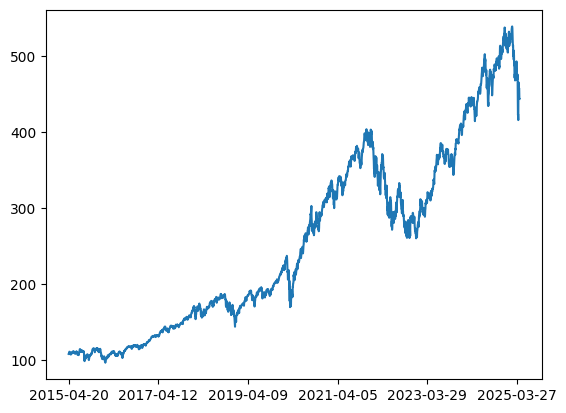

In [6]:
# Plot the overall data movement
dataset['Close'].plot()

# Data Cleaning and Preparation

In [7]:
# Find rows with any missing values
rows_with_na = dataset[dataset.isnull().any(axis=1)]

# Display how many rows have missing values
print(f"Number of rows with missing values: {len(rows_with_na)}")

Number of rows with missing values: 0


In [8]:
# Train–test split (80% for training, 20% for testing)
# Extract the 'Close' column as a NumPy array
X = dataset["Close"].astype(float).values

# Define split ratio
validation_size = 0.2
train_size = int(len(X) * (1 - validation_size))

# Perform the split
X_train = X[:train_size]
X_test = X[train_size:]

print(len(X_train))
print(len(X_test))

2012
504


# Model Implementation

In [9]:
# Deep Q-Network (DQN) Agent Class
class DQNAgent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size  # Size of input vector (state)
        self.action_size = 3
        self.memory = deque(maxlen=2100)  # Experience replay memory
        self.gamma = 0.95  # Discount factor for future rewards
        self.epsilon = 1.0  # Initial exploration rate (epsilon-greedy)
        self.epsilon_min = 0.01  # Minimum epsilon
        self.epsilon_decay = 0.995  # Rate at which epsilon decays
        self.learning_rate = 0.001  # Learning rate for the optimizer
        self.is_eval = is_eval
        self.model_name = model_name

        # Main Q-network and Target network
        self.model = load_model(model_name) if is_eval else self._build_model()  # Current Q-value estimator
        self.target_model = self._build_model()  # Target Q-value estimator
        self.update_target_model()  # Initialize target model weights

    def _build_model(self):
        # Build a simple feedforward neural network with two hidden layers
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))  # First hidden layer
        model.add(Dense(24, activation='relu'))  # Second hidden layer
        model.add(Dense(self.action_size, activation='linear'))  # Output layer for Q-values
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # Copy weights from main model to target model
        # Helps stabilize training by keeping the target fixed for some time
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        # Store a transition in memory for experience replay
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        # Epsilon-greedy policy: choose random action with probability epsilon
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        # Otherwise, choose best action predicted by Q-network
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        # Sample a minibatch of transitions from memory
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            # Predict Q-values using the target network (for stability)
            target = self.model.predict(state, verbose=0)
            if done:
                target[0][action] = reward  # If episode ends, no future reward
            else:
                # Q-learning update with target network
                t = self.target_model.predict(next_state, verbose=0)
                target[0][action] = reward + self.gamma * np.amax(t[0])

            # Train the main model on the updated Q-value for the action
            self.model.fit(state, target, epochs=1, verbose=0)

        # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [10]:
def get_state(prices, t, window_size):
    """
    Generate sigmoid-normalized momentum state vector at time t.
    Includes padding with prices[0] when t < window_size.
    Returns a (1, window_size) shaped array.
    """
    state = []
    for i in range(t - window_size + 1, t + 1):
        if i <= 0:
            # Pad with sigmoid(0) = 0.5 when using prices[0] - prices[0]
            state.append(0.5)
        else:
            change = prices[i] - prices[i - 1]
            normalized = 1 / (1 + np.exp(-change))
            state.append(normalized)
    return np.array([state])

# Model Training

In [12]:
# Training parameters
window_size = 2
agent = DQNAgent(window_size)
batch_size = 32
episodes = 50
prices = X_train
x = 1  # Shares per trade
replay_steps = 100

states = [get_state(prices, t, window_size) for t in range(len(prices))]
# --- Training Loop ---
for e in range(episodes):
    start = time.time()
    print(f"Episode {e + 1}/{episodes}")
    total_profit = 0
    inventory = []
    state = states[window_size - 1]

    buy_points = []
    sell_points = []

    for t in range(window_size - 1, len(prices) - 1):
        action = agent.act(state)
        next_state = states[t + 1]
        done = (t == len(prices) - 2)

        # --- Inline step logic ---
        reward = 0
        if action == 1:  # Buy
            inventory.append(prices[t])
            buy_points.append((t, prices[t]))
        elif action == 2 and len(inventory) > 0:  # Sell
            bought_price = inventory.pop(0)
            reward = (prices[t] - bought_price) * x
            total_profit += reward
            sell_points.append((t, prices[t]))

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if len(agent.memory) > batch_size and t % replay_steps == 0:
          agent.replay(batch_size)


        if done:
            print(f"Total Profit: {round(total_profit, 2)}")
            break

    # Update target network every 5 episodes
    if (e + 1) % 5 == 0:
        agent.update_target_model()

    # Save model every 10 episodes
    if (e + 1) % 10 == 0:
        agent.model.save(f"model_ep{e+1}.h5")

    # --- Plot trading decisions ---
    plt.figure(figsize=(16, 8))
    plt.plot(prices, label='Price')
    if buy_points:
        buy_t, buy_p = zip(*buy_points)
        plt.scatter(buy_t, buy_p, marker='^', color='green', label='Buy', s=100)
    if sell_points:
        sell_t, sell_p = zip(*sell_points)
        plt.scatter(sell_t, sell_p, marker='v', color='red', label='Sell', s=100)
    plt.title(f"Episode {e + 1} — Total Profit: {round(total_profit, 2)}")
    plt.xlabel("Time Step")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    # Save the figure only (no display)
    plt.savefig(f"plots/trading_episode_{e+1}.png", dpi=300, bbox_inches='tight')
    plt.close()  # Close the figure to release memory

    print(f"Episode Time: {round(time.time() - start, 2)} seconds")

Episode 1/50
Total Profit: 1423.48
Episode Time: 127.75 seconds
Episode 2/50
Total Profit: -109.92
Episode Time: 138.12 seconds
Episode 3/50
Total Profit: 542.91
Episode Time: 149.67 seconds
Episode 4/50
Total Profit: 345.99
Episode Time: 159.99 seconds
Episode 5/50
Total Profit: 774.53
Episode Time: 170.44 seconds
Episode 6/50
Total Profit: 108.3
Episode Time: 175.19 seconds
Episode 7/50
Total Profit: 505.11
Episode Time: 186.07 seconds
Episode 8/50
Total Profit: 1882.13
Episode Time: 188.01 seconds
Episode 9/50
Total Profit: 500.16
Episode Time: 194.61 seconds
Episode 10/50
Total Profit: 254.16


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode Time: 200.12 seconds
Episode 11/50
Total Profit: 27454.24
Episode Time: 204.11 seconds
Episode 12/50
Total Profit: 9.4
Episode Time: 207.81 seconds
Episode 13/50
Total Profit: 131.94
Episode Time: 214.68 seconds
Episode 14/50
Total Profit: 2496.0
Episode Time: 217.43 seconds
Episode 15/50
Total Profit: -337.77
Episode Time: 220.92 seconds
Episode 16/50
Total Profit: 37761.47
Episode Time: 224.06 seconds
Episode 17/50
Total Profit: 315.82
Episode Time: 224.84 seconds
Episode 18/50
Total Profit: 14385.9
Episode Time: 232.14 seconds
Episode 19/50
Total Profit: 350.29
Episode Time: 231.76 seconds
Episode 20/50
Total Profit: 3983.81
Episode Time: 232.07 seconds
Episode 21/50
Total Profit: 25086.42
Episode Time: 233.94 seconds
Episode 22/50
Total Profit: 86.4
Episode Time: 236.54 seconds
Episode 23/50
Total Profit: -766.07
Episode Time: 238.22 seconds
Episode 24/50
Total Profit: 120581.99
Episode Time: 238.65 seconds
Episode 25/50
Total Profit: 11.27
Episode Time: 243.7 seconds
Episo

# Model testing

Evaluation on test set completed — Total Profit: -31.69


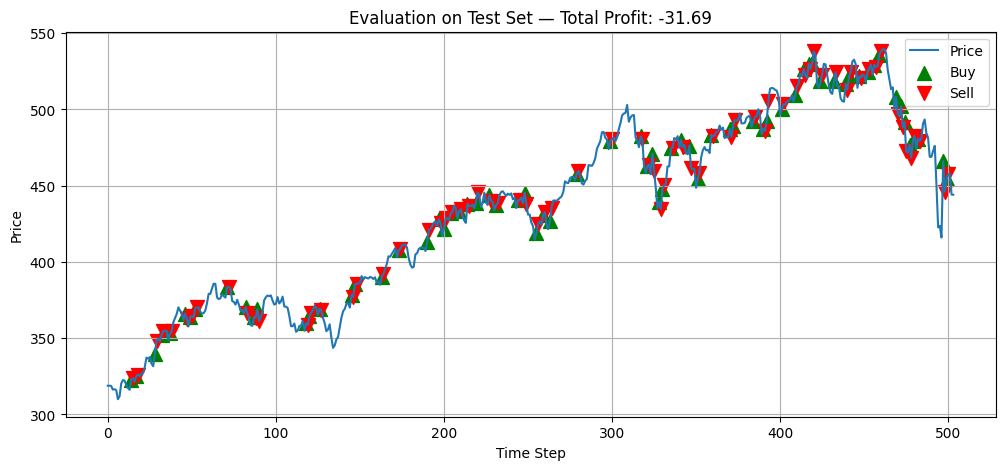

In [14]:
# --- Set up for evaluation on test data ---
prices = X_test  # Use test prices
inventory = []
total_profit = 0
x = 1  # Shares per trade
window_size = 2  # Same as training
is_eval = True
model_name = f"model_ep{episodes}.h5"
agent = DQNAgent(window_size, is_eval, model_name)

buy_points = []
sell_points = []

state = get_state(prices, window_size - 1, window_size)

# --- Evaluation Loop ---
for t in range(window_size, len(prices) - 1):
    action = agent.act(state)
    next_state = get_state(prices, t + 1, window_size)

    reward = 0
    if action == 1:  # Buy
        inventory.append(prices[t])
        buy_points.append((t, prices[t]))
    elif action == 2 and len(inventory) > 0:  # Sell
        bought_price = inventory.pop(0)
        reward = (prices[t] - bought_price) * x
        total_profit += reward
        sell_points.append((t, prices[t]))

    state = next_state

print(f"Evaluation on test set completed — Total Profit: {round(total_profit, 2)}")
plt.figure(figsize=(12, 5))
plt.plot(prices, label='Price')
if buy_points:
    buy_t, buy_p = zip(*buy_points)
    plt.scatter(buy_t, buy_p, marker='^', color='green', label='Buy', s=100)
if sell_points:
    sell_t, sell_p = zip(*sell_points)
    plt.scatter(sell_t, sell_p, marker='v', color='red', label='Sell', s=100)
plt.title(f"Evaluation on Test Set — Total Profit: {round(total_profit, 2)}")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
